In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('hw2_data/snli_train.tsv',delimiter='\t')
val = pd.read_csv("hw2_data/snli_val.tsv",delimiter='\t')

In [3]:
train_data = train[['sentence1','sentence2']]
train_targets = np.array(train['label'])


val_data = val[['sentence1','sentence2']]
val_targets = np.array(val['label'])


In [4]:
train_targets = np.where(train_targets=='entailment',1,train_targets)
train_targets = np.where(train_targets=='neutral',0,train_targets)
train_targets = np.where(train_targets=='contradiction',2,train_targets)


val_targets = np.where(val_targets=='entailment',1,val_targets)
val_targets = np.where(val_targets=='neutral',0,val_targets)
val_targets = np.where(val_targets=='contradiction',2,val_targets)




In [5]:
ft_home = './'
words_to_load = 50000

# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1


with open(ft_home + 'wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft = np.zeros((words_to_load+2, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = ['<pad>','<unk>']
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i+2, :] = np.asarray(s[1:])
        words_ft[s[0]] = i+2
        idx2words_ft[i+2] = s[0]
        ordered_words_ft.append(s[0])
    words_ft['<pad>'] = PAD_IDX 
    words_ft['<unk>'] = UNK_IDX   
    

In [6]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [words_ft[token] if token in words_ft else UNK_IDX for token in tokens.split(' ')]
        indices_data.append(index_list)
    return indices_data

train_data_sentence1_indices = token2index_dataset(train_data['sentence1'])
train_data_sentence2_indices = token2index_dataset(train_data['sentence2'])

val_data_sentence1_indices = token2index_dataset(val_data['sentence1'])
val_data_sentence2_indices = token2index_dataset(val_data['sentence2'])


# double checking
print ("Train dataset of sentence1 size is {}".format(len(train_data_sentence1_indices)))
print ("Train dataset of sentence2 size is {}".format(len(train_data_sentence2_indices)))


Train dataset of sentence1 size is 100000
Train dataset of sentence2 size is 100000


In [7]:
#MAX_SENTENCE_LENGTH = 80
    
import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list_1,data_list_2, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list_1 = data_list_1
        self.data_list_2 = data_list_2
        self.target_list = target_list
        assert (len(self.data_list_1) == len(self.target_list))

    def __len__(self):
        return len(self.target_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """

        token_idx_1 = self.data_list_1[key]
        token_idx_2 = self.data_list_2[key]
        label = self.target_list[key]
        return [token_idx_1,token_idx_2, len(token_idx_1),len(token_idx_2), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list_1 = []
    data_list_2 = []
    label_list = []
    length_list_1 = []
    length_list_2 = []

    for datum in batch:
        label_list.append(datum[4])
        length_list_1.append(datum[2])
        #print(datum[2])
        length_list_2.append(datum[3])
        #print(datum[3])

    # padding
    for datum in batch:
        
        max_s1 = max (length_list_1) 
        max_s2 = max (length_list_2) 


        padded_vec_1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,max_s1-datum[2])), 
                                mode="constant", constant_values=0)
        data_list_1.append(padded_vec_1)
        
        #print(data_list_1[0])
        
        padded_vec_2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,max_s2-datum[3])), 
                                mode="constant", constant_values=0)
        data_list_2.append(padded_vec_2)
        #print(data_list_2[0])
        
    return [torch.from_numpy(np.array(data_list_1)),torch.from_numpy(np.array(data_list_2)),torch.from_numpy(np.array(length_list_1)), torch.LongTensor(length_list_2),torch.LongTensor(label_list)]

BATCH_SIZE = 100
train_dataset = NewsGroupDataset(train_data_sentence1_indices,train_data_sentence2_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_sentence1_indices,val_data_sentence2_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)


---
## Search for the hidden layer sizes

In [14]:

# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F


class SNLI_CNN(nn.Module):
    def __init__(self,embeddings, emb_size, hidden_size, num_layers, num_classes, vocab_size=50000,kernel_size=3,FC_hiden=50):

        super(SNLI_CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.num_classes = num_classes
        self.emb_size = emb_size
        
        self.embed = nn.Embedding.from_pretrained(torch.from_numpy(embeddings).float(), freeze=False, sparse=False)
        
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size, padding=1)

                
        self.linear = nn.Sequential(
            #nn.Linear(hidden_size,FC_hiden),
            nn.Linear(hidden_size*2,FC_hiden),
            nn.ReLU(),
            #nn.Dropout(),
            nn.Linear(FC_hiden,num_classes),
            nn.ReLU())     
        
    def forward(self, data_1,data_2,length_1,length_2):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        
        batch_size_1, seq_len_1 = data_1.size()
        batch_size_2, seq_len_2 = data_2.size()

        S1 = self.embed(data_1)
        m1 = (data_1 == 1)
        #print(m1)
        m1 = m1.unsqueeze(2).repeat(1, 1, self.emb_size).float()
        S1 = m1 * S1 + (1-m1) * S1.clone().detach()
        
 
        #print(S1.size())

        S2 = self.embed(data_2)
        m2 = (data_2 == 1)
        m2 = m2.unsqueeze(2).repeat(1, 1, self.emb_size).float()
        S2 = m2 * S2 + (1-m2) * S2.clone().detach()

        
        #print(S1.size())
        
        S1 = self.conv1(S1.transpose(1,2)).transpose(1,2)
        S1 = F.relu(S1.contiguous().view(-1, S1.size(-1))).view(BATCH_SIZE, S1.size(1), S1.size(-1))

        #print(S1.size())

        S1 = self.conv2(S1.transpose(1,2)).transpose(1,2)
        S1 = F.relu(S1.contiguous().view(-1, S1.size(-1))).view(BATCH_SIZE, S1.size(1), S1.size(-1))
        
        S1 = S1.max(dim=1)
        #print(S1[0].size())

        S2 = self.conv1(S2.transpose(1,2)).transpose(1,2)
        S2 = F.relu(S2.contiguous().view(-1, S2.size(-1))).view(BATCH_SIZE, S2.size(1), S2.size(-1))

        S2 = self.conv2(S2.transpose(1,2)).transpose(1,2)
        S2 = F.relu(S2.contiguous().view(-1, S2.size(-1))).view(BATCH_SIZE, S2.size(1), S2.size(-1))
        S2 = torch.max(S2, dim=1)
        
        out = torch.cat([S1[0], S2[0]], 1)
        #print(out.size())
        
        logits = self.linear(out)
        
        return logits
    
    
    

In [15]:

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data_1,data_2, lengths_1,lengths_2, labels in loader:
        data_batch1,data_batch2, length_batch1,length_batch2, label_batch = data_1.cuda(),data_2.cuda(), lengths_1.cuda(),lengths_2.cuda(), labels.cuda()
        outputs = F.softmax(model(data_batch1,data_batch2, length_batch1,length_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
       
        #print(outputs)
        total += label_batch.size(0)
        correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [16]:
hidden_sizes = [50,100,140,160,200,250]

learning_rate = 0.0005
num_epochs = 20 # number epoch to train


train_losses=np.zeros((num_epochs,len(hidden_sizes)))
val_accs=np.zeros((num_epochs,len(hidden_sizes)))
train_accs=np.zeros((num_epochs,len(hidden_sizes)))

for count, em in enumerate(hidden_sizes):
    model = SNLI_CNN(loaded_embeddings_ft,emb_size=300, hidden_size=em, num_layers=2, num_classes=3,vocab_size=50000).cuda()

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        epoch_loss=[]
        val_acc = 0
        tra_acc = 0
        for i, (data_1,data_2, lengths_1,lengths_2, labels) in enumerate(train_loader):
            model.train()
            data_batch1,data_batch2,length_batch1,length_batch2,label_batch = data_1.cuda(),data_2.cuda(), lengths_1.cuda(),lengths_2.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(data_batch1,data_batch2, length_batch1,length_batch2)
            #print(outputs)
            #print(label_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            epoch_loss.append(loss)
            #print(np.array(loss))
            optimizer.step()
            # validate every 32 iterations
            if i > 0 and i % (BATCH_SIZE-1) == 0:
                # validate
                tra_acc = test_model(train_loader, model)
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))

        temp_loss = [i.detach().cpu().numpy() for i in epoch_loss]
        train_losses[epoch,count] = sum(temp_loss)/BATCH_SIZE

        train_accs[epoch,count] = tra_acc
        val_accs[epoch,count] = val_acc
    

Epoch: [1/20], Step: [100/1000], Validation Acc: 46.1
Epoch: [1/20], Step: [199/1000], Validation Acc: 55.6
Epoch: [1/20], Step: [298/1000], Validation Acc: 59.8
Epoch: [1/20], Step: [397/1000], Validation Acc: 58.9
Epoch: [1/20], Step: [496/1000], Validation Acc: 59.7
Epoch: [1/20], Step: [595/1000], Validation Acc: 59.4
Epoch: [1/20], Step: [694/1000], Validation Acc: 59.9
Epoch: [1/20], Step: [793/1000], Validation Acc: 61.2
Epoch: [1/20], Step: [892/1000], Validation Acc: 62.1
Epoch: [1/20], Step: [991/1000], Validation Acc: 62.1
Epoch: [2/20], Step: [100/1000], Validation Acc: 62.2
Epoch: [2/20], Step: [199/1000], Validation Acc: 62.1
Epoch: [2/20], Step: [298/1000], Validation Acc: 62.7
Epoch: [2/20], Step: [397/1000], Validation Acc: 62.5
Epoch: [2/20], Step: [496/1000], Validation Acc: 63.4
Epoch: [2/20], Step: [595/1000], Validation Acc: 62.5
Epoch: [2/20], Step: [694/1000], Validation Acc: 64.2
Epoch: [2/20], Step: [793/1000], Validation Acc: 63.5
Epoch: [2/20], Step: [892/10

Epoch: [16/20], Step: [199/1000], Validation Acc: 65.7
Epoch: [16/20], Step: [298/1000], Validation Acc: 66.2
Epoch: [16/20], Step: [397/1000], Validation Acc: 66.1
Epoch: [16/20], Step: [496/1000], Validation Acc: 66.2
Epoch: [16/20], Step: [595/1000], Validation Acc: 66.9
Epoch: [16/20], Step: [694/1000], Validation Acc: 64.5
Epoch: [16/20], Step: [793/1000], Validation Acc: 66.1
Epoch: [16/20], Step: [892/1000], Validation Acc: 67.1
Epoch: [16/20], Step: [991/1000], Validation Acc: 66.2
Epoch: [17/20], Step: [100/1000], Validation Acc: 66.5
Epoch: [17/20], Step: [199/1000], Validation Acc: 65.0
Epoch: [17/20], Step: [298/1000], Validation Acc: 66.9
Epoch: [17/20], Step: [397/1000], Validation Acc: 65.6
Epoch: [17/20], Step: [496/1000], Validation Acc: 65.6
Epoch: [17/20], Step: [595/1000], Validation Acc: 66.4
Epoch: [17/20], Step: [694/1000], Validation Acc: 65.0
Epoch: [17/20], Step: [793/1000], Validation Acc: 65.7
Epoch: [17/20], Step: [892/1000], Validation Acc: 66.1
Epoch: [17

Epoch: [11/20], Step: [298/1000], Validation Acc: 67.4
Epoch: [11/20], Step: [397/1000], Validation Acc: 67.4
Epoch: [11/20], Step: [496/1000], Validation Acc: 67.8
Epoch: [11/20], Step: [595/1000], Validation Acc: 66.9
Epoch: [11/20], Step: [694/1000], Validation Acc: 65.9
Epoch: [11/20], Step: [793/1000], Validation Acc: 66.9
Epoch: [11/20], Step: [892/1000], Validation Acc: 66.8
Epoch: [11/20], Step: [991/1000], Validation Acc: 65.6
Epoch: [12/20], Step: [100/1000], Validation Acc: 66.8
Epoch: [12/20], Step: [199/1000], Validation Acc: 66.9
Epoch: [12/20], Step: [298/1000], Validation Acc: 67.1
Epoch: [12/20], Step: [397/1000], Validation Acc: 66.9
Epoch: [12/20], Step: [496/1000], Validation Acc: 65.3
Epoch: [12/20], Step: [595/1000], Validation Acc: 67.4
Epoch: [12/20], Step: [694/1000], Validation Acc: 65.8
Epoch: [12/20], Step: [793/1000], Validation Acc: 67.2
Epoch: [12/20], Step: [892/1000], Validation Acc: 66.6
Epoch: [12/20], Step: [991/1000], Validation Acc: 65.6
Epoch: [13

Epoch: [6/20], Step: [298/1000], Validation Acc: 33.8
Epoch: [6/20], Step: [397/1000], Validation Acc: 33.8
Epoch: [6/20], Step: [496/1000], Validation Acc: 33.8
Epoch: [6/20], Step: [595/1000], Validation Acc: 33.8
Epoch: [6/20], Step: [694/1000], Validation Acc: 33.8
Epoch: [6/20], Step: [793/1000], Validation Acc: 33.8
Epoch: [6/20], Step: [892/1000], Validation Acc: 33.8
Epoch: [6/20], Step: [991/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [100/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [199/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [298/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [397/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [496/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [595/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [694/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [793/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [892/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [991/1000], Validation Acc: 33.8
Epoch: [8/20], Step: [100/10

Epoch: [1/20], Step: [298/1000], Validation Acc: 33.8
Epoch: [1/20], Step: [397/1000], Validation Acc: 33.8
Epoch: [1/20], Step: [496/1000], Validation Acc: 33.8
Epoch: [1/20], Step: [595/1000], Validation Acc: 33.8
Epoch: [1/20], Step: [694/1000], Validation Acc: 33.8
Epoch: [1/20], Step: [793/1000], Validation Acc: 33.8
Epoch: [1/20], Step: [892/1000], Validation Acc: 33.8
Epoch: [1/20], Step: [991/1000], Validation Acc: 33.8
Epoch: [2/20], Step: [100/1000], Validation Acc: 33.8
Epoch: [2/20], Step: [199/1000], Validation Acc: 33.8
Epoch: [2/20], Step: [298/1000], Validation Acc: 33.8
Epoch: [2/20], Step: [397/1000], Validation Acc: 33.8
Epoch: [2/20], Step: [496/1000], Validation Acc: 33.8
Epoch: [2/20], Step: [595/1000], Validation Acc: 33.8
Epoch: [2/20], Step: [694/1000], Validation Acc: 33.8
Epoch: [2/20], Step: [793/1000], Validation Acc: 33.8
Epoch: [2/20], Step: [892/1000], Validation Acc: 33.8
Epoch: [2/20], Step: [991/1000], Validation Acc: 33.8
Epoch: [3/20], Step: [100/10

Epoch: [16/20], Step: [397/1000], Validation Acc: 33.8
Epoch: [16/20], Step: [496/1000], Validation Acc: 33.8
Epoch: [16/20], Step: [595/1000], Validation Acc: 33.8
Epoch: [16/20], Step: [694/1000], Validation Acc: 33.8
Epoch: [16/20], Step: [793/1000], Validation Acc: 33.8
Epoch: [16/20], Step: [892/1000], Validation Acc: 33.8
Epoch: [16/20], Step: [991/1000], Validation Acc: 33.8
Epoch: [17/20], Step: [100/1000], Validation Acc: 33.8
Epoch: [17/20], Step: [199/1000], Validation Acc: 33.8
Epoch: [17/20], Step: [298/1000], Validation Acc: 33.8
Epoch: [17/20], Step: [397/1000], Validation Acc: 33.8
Epoch: [17/20], Step: [496/1000], Validation Acc: 33.8
Epoch: [17/20], Step: [595/1000], Validation Acc: 33.8
Epoch: [17/20], Step: [694/1000], Validation Acc: 33.8
Epoch: [17/20], Step: [793/1000], Validation Acc: 33.8
Epoch: [17/20], Step: [892/1000], Validation Acc: 33.8
Epoch: [17/20], Step: [991/1000], Validation Acc: 33.8
Epoch: [18/20], Step: [100/1000], Validation Acc: 33.8
Epoch: [18

Epoch: [11/20], Step: [496/1000], Validation Acc: 65.6
Epoch: [11/20], Step: [595/1000], Validation Acc: 66.3
Epoch: [11/20], Step: [694/1000], Validation Acc: 66.6
Epoch: [11/20], Step: [793/1000], Validation Acc: 66.3
Epoch: [11/20], Step: [892/1000], Validation Acc: 67.5
Epoch: [11/20], Step: [991/1000], Validation Acc: 64.8
Epoch: [12/20], Step: [100/1000], Validation Acc: 65.8
Epoch: [12/20], Step: [199/1000], Validation Acc: 65.4
Epoch: [12/20], Step: [298/1000], Validation Acc: 64.7
Epoch: [12/20], Step: [397/1000], Validation Acc: 66.0
Epoch: [12/20], Step: [496/1000], Validation Acc: 66.1
Epoch: [12/20], Step: [595/1000], Validation Acc: 65.7
Epoch: [12/20], Step: [694/1000], Validation Acc: 67.0
Epoch: [12/20], Step: [793/1000], Validation Acc: 66.1
Epoch: [12/20], Step: [892/1000], Validation Acc: 65.4
Epoch: [12/20], Step: [991/1000], Validation Acc: 65.9
Epoch: [13/20], Step: [100/1000], Validation Acc: 67.0
Epoch: [13/20], Step: [199/1000], Validation Acc: 66.9
Epoch: [13

Epoch: [6/20], Step: [496/1000], Validation Acc: 33.8
Epoch: [6/20], Step: [595/1000], Validation Acc: 33.8
Epoch: [6/20], Step: [694/1000], Validation Acc: 33.8
Epoch: [6/20], Step: [793/1000], Validation Acc: 33.8
Epoch: [6/20], Step: [892/1000], Validation Acc: 33.8
Epoch: [6/20], Step: [991/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [100/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [199/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [298/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [397/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [496/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [595/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [694/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [793/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [892/1000], Validation Acc: 33.8
Epoch: [7/20], Step: [991/1000], Validation Acc: 33.8
Epoch: [8/20], Step: [100/1000], Validation Acc: 33.8
Epoch: [8/20], Step: [199/1000], Validation Acc: 33.8
Epoch: [8/20], Step: [298/10

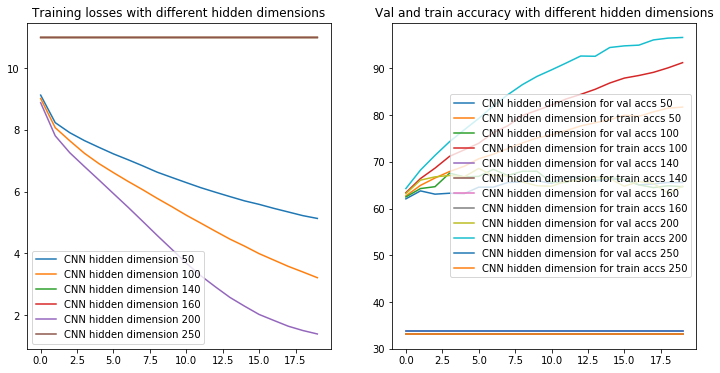

In [17]:
# Plot the results
fig, axs = plt.subplots(1,2,figsize=(12,6))
for i in range(len(train_losses[0,:])):
    axs[0].plot(train_losses[:,i],label= "CNN hidden dimension " +str(hidden_sizes[i])) 

axs[0].set_title("Training losses with different hidden dimensions")
axs[0].legend()

for i in range(len(val_accs[0,:])):
    axs[1].plot(val_accs[:,i],label= "CNN hidden dimension for val accs " +str(hidden_sizes[i])) 
    axs[1].plot(train_accs[:,i],label= "CNN hidden dimension for train accs " +str(hidden_sizes[i])) 

axs[1].set_title("Val and train accuracy with different hidden dimensions")
axs[1].legend()



---
## Search for the kernel sizes

In [21]:

# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F


class SNLI_CNN(nn.Module):
    def __init__(self,embeddings, emb_size, hidden_size, num_layers, num_classes, vocab_size=50000,kernel_size=3,FC_hiden=50):

        super(SNLI_CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.num_classes = num_classes
        self.emb_size = emb_size
        
        self.embed = nn.Embedding.from_pretrained(torch.from_numpy(embeddings).float(), freeze=False, sparse=False)
        
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size, padding=1)

                
        self.linear = nn.Sequential(
            #nn.Linear(hidden_size,FC_hiden),
            nn.Linear(hidden_size*2,FC_hiden),
            nn.ReLU(),
            #nn.Dropout(),
            nn.Linear(FC_hiden,num_classes),
            nn.ReLU())     
        
    def forward(self, data_1,data_2,length_1,length_2):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        
        batch_size_1, seq_len_1 = data_1.size()
        batch_size_2, seq_len_2 = data_2.size()

        S1 = self.embed(data_1)
        m1 = (data_1 == 1)
        #print(m1)
        m1 = m1.unsqueeze(2).repeat(1, 1, self.emb_size).float()
        S1 = m1 * S1 + (1-m1) * S1.clone().detach()
        
 
        #print(S1.size())

        S2 = self.embed(data_2)
        m2 = (data_2 == 1)
        m2 = m2.unsqueeze(2).repeat(1, 1, self.emb_size).float()
        S2 = m2 * S2 + (1-m2) * S2.clone().detach()

        
        #print(S1.size())
        
        S1 = self.conv1(S1.transpose(1,2)).transpose(1,2)
        S1 = F.relu(S1.contiguous().view(-1, S1.size(-1))).view(BATCH_SIZE, S1.size(1), S1.size(-1))

        #print(S1.size())

        S1 = self.conv2(S1.transpose(1,2)).transpose(1,2)
        S1 = F.relu(S1.contiguous().view(-1, S1.size(-1))).view(BATCH_SIZE, S1.size(1), S1.size(-1))
        
        S1 = S1.max(dim=1)
        #print(S1[0].size())

        S2 = self.conv1(S2.transpose(1,2)).transpose(1,2)
        S2 = F.relu(S2.contiguous().view(-1, S2.size(-1))).view(BATCH_SIZE, S2.size(1), S2.size(-1))

        S2 = self.conv2(S2.transpose(1,2)).transpose(1,2)
        S2 = F.relu(S2.contiguous().view(-1, S2.size(-1))).view(BATCH_SIZE, S2.size(1), S2.size(-1))
        S2 = torch.max(S2, dim=1)
        
        out = torch.cat([S1[0], S2[0]], 1)
        #print(out.size())
        
        logits = self.linear(out)
        
        return logits
    
    
    

In [22]:
kernel_sizes = [1,2,3,4]

learning_rate = 0.001
num_epochs = 10 # number epoch to train


train_losses=np.zeros((num_epochs,len(kernel_sizes)))
val_accs=np.zeros((num_epochs,len(kernel_sizes)))
train_accs=np.zeros((num_epochs,len(kernel_sizes)))

for count, ks in enumerate(kernel_sizes):
    model = SNLI_CNN(loaded_embeddings_ft,emb_size=300, hidden_size=200, num_layers=2, num_classes=3,vocab_size=50000,kernel_size=ks).cuda()

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        epoch_loss=[]
        val_acc = 0
        tra_acc = 0
        for i, (data_1,data_2, lengths_1,lengths_2, labels) in enumerate(train_loader):
            model.train()
            data_batch1,data_batch2,length_batch1,length_batch2,label_batch = data_1.cuda(),data_2.cuda(), lengths_1.cuda(),lengths_2.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(data_batch1,data_batch2, length_batch1,length_batch2)
            #print(outputs)
            #print(label_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            epoch_loss.append(loss)
            #print(np.array(loss))
            optimizer.step()
            # validate every 32 iterations
            if i > 0 and i % (BATCH_SIZE-1) == 0:
                # validate
                tra_acc = test_model(train_loader, model)
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))

        temp_loss = [i.detach().cpu().numpy() for i in epoch_loss]
        train_losses[epoch,count] = sum(temp_loss)/BATCH_SIZE

        train_accs[epoch,count] = tra_acc
        val_accs[epoch,count] = val_acc
    

Epoch: [1/10], Step: [100/1000], Validation Acc: 43.7
Epoch: [1/10], Step: [199/1000], Validation Acc: 44.3
Epoch: [1/10], Step: [298/1000], Validation Acc: 44.8
Epoch: [1/10], Step: [397/1000], Validation Acc: 45.1
Epoch: [1/10], Step: [496/1000], Validation Acc: 45.7
Epoch: [1/10], Step: [595/1000], Validation Acc: 45.0
Epoch: [1/10], Step: [694/1000], Validation Acc: 46.8
Epoch: [1/10], Step: [793/1000], Validation Acc: 46.3
Epoch: [1/10], Step: [892/1000], Validation Acc: 45.1
Epoch: [1/10], Step: [991/1000], Validation Acc: 45.5
Epoch: [2/10], Step: [100/1000], Validation Acc: 46.1
Epoch: [2/10], Step: [199/1000], Validation Acc: 46.4
Epoch: [2/10], Step: [298/1000], Validation Acc: 47.2
Epoch: [2/10], Step: [397/1000], Validation Acc: 47.3
Epoch: [2/10], Step: [496/1000], Validation Acc: 46.4
Epoch: [2/10], Step: [595/1000], Validation Acc: 46.3
Epoch: [2/10], Step: [694/1000], Validation Acc: 46.8
Epoch: [2/10], Step: [793/1000], Validation Acc: 46.7
Epoch: [2/10], Step: [892/10

Epoch: [6/10], Step: [298/1000], Validation Acc: 70.5
Epoch: [6/10], Step: [397/1000], Validation Acc: 69.6
Epoch: [6/10], Step: [496/1000], Validation Acc: 70.1
Epoch: [6/10], Step: [595/1000], Validation Acc: 70.0
Epoch: [6/10], Step: [694/1000], Validation Acc: 70.7
Epoch: [6/10], Step: [793/1000], Validation Acc: 70.5
Epoch: [6/10], Step: [892/1000], Validation Acc: 69.6
Epoch: [6/10], Step: [991/1000], Validation Acc: 71.1
Epoch: [7/10], Step: [100/1000], Validation Acc: 71.0
Epoch: [7/10], Step: [199/1000], Validation Acc: 69.1
Epoch: [7/10], Step: [298/1000], Validation Acc: 68.5
Epoch: [7/10], Step: [397/1000], Validation Acc: 70.5
Epoch: [7/10], Step: [496/1000], Validation Acc: 68.9
Epoch: [7/10], Step: [595/1000], Validation Acc: 69.9
Epoch: [7/10], Step: [694/1000], Validation Acc: 70.5
Epoch: [7/10], Step: [793/1000], Validation Acc: 71.3
Epoch: [7/10], Step: [892/1000], Validation Acc: 71.2
Epoch: [7/10], Step: [991/1000], Validation Acc: 70.7
Epoch: [8/10], Step: [100/10

Epoch: [1/10], Step: [496/1000], Validation Acc: 49.6
Epoch: [1/10], Step: [595/1000], Validation Acc: 49.5
Epoch: [1/10], Step: [694/1000], Validation Acc: 50.6
Epoch: [1/10], Step: [793/1000], Validation Acc: 50.3
Epoch: [1/10], Step: [892/1000], Validation Acc: 51.7
Epoch: [1/10], Step: [991/1000], Validation Acc: 51.3
Epoch: [2/10], Step: [100/1000], Validation Acc: 50.5
Epoch: [2/10], Step: [199/1000], Validation Acc: 50.3
Epoch: [2/10], Step: [298/1000], Validation Acc: 49.9
Epoch: [2/10], Step: [397/1000], Validation Acc: 50.6
Epoch: [2/10], Step: [496/1000], Validation Acc: 50.4
Epoch: [2/10], Step: [595/1000], Validation Acc: 51.7
Epoch: [2/10], Step: [694/1000], Validation Acc: 50.5
Epoch: [2/10], Step: [793/1000], Validation Acc: 51.4
Epoch: [2/10], Step: [892/1000], Validation Acc: 51.6
Epoch: [2/10], Step: [991/1000], Validation Acc: 52.8
Epoch: [3/10], Step: [100/1000], Validation Acc: 52.1
Epoch: [3/10], Step: [199/1000], Validation Acc: 50.3
Epoch: [3/10], Step: [298/10

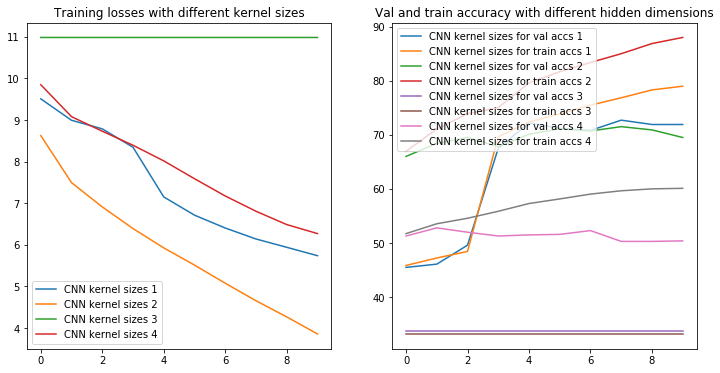

In [23]:
# Plot the results
fig, axs = plt.subplots(1,2,figsize=(12,6))
for i in range(len(train_losses[0,:])):
    axs[0].plot(train_losses[:,i],label= "CNN kernel sizes " +str(kernel_sizes[i])) 

axs[0].set_title("Training losses with different kernel sizes")
axs[0].legend()

for i in range(len(val_accs[0,:])):
    axs[1].plot(val_accs[:,i],label= "CNN kernel sizes for val accs " +str(kernel_sizes[i])) 
    axs[1].plot(train_accs[:,i],label= "CNN kernel sizes for train accs " +str(kernel_sizes[i])) 

axs[1].set_title("Val and train accuracy with different hidden dimensions")
axs[1].legend()



---
## Investigate whether element-wise multiplication helps

In [25]:

# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F


class SNLI_CNN(nn.Module):
    def __init__(self,embeddings, emb_size, hidden_size, num_layers, num_classes, vocab_size=50000,kernel_size=3,FC_hiden=50):

        super(SNLI_CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.num_classes = num_classes
        self.emb_size = emb_size
        
        self.embed = nn.Embedding.from_pretrained(torch.from_numpy(embeddings).float(), freeze=False, sparse=False)
        
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size, padding=1)

                
        self.linear = nn.Sequential(
            nn.Linear(hidden_size,FC_hiden),
            #nn.Linear(hidden_size*2,FC_hiden),
            nn.ReLU(),
            #nn.Dropout(),
            nn.Linear(FC_hiden,num_classes),
            nn.ReLU())     
        
    def forward(self, data_1,data_2,length_1,length_2):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        
        batch_size_1, seq_len_1 = data_1.size()
        batch_size_2, seq_len_2 = data_2.size()

        S1 = self.embed(data_1)
        m1 = (data_1 == 1)
        #print(m1)
        m1 = m1.unsqueeze(2).repeat(1, 1, self.emb_size).float()
        S1 = m1 * S1 + (1-m1) * S1.clone().detach()
        
 
        #print(S1.size())

        S2 = self.embed(data_2)
        m2 = (data_2 == 1)
        m2 = m2.unsqueeze(2).repeat(1, 1, self.emb_size).float()
        S2 = m2 * S2 + (1-m2) * S2.clone().detach()

        
        #print(S1.size())
        
        S1 = self.conv1(S1.transpose(1,2)).transpose(1,2)
        S1 = F.relu(S1.contiguous().view(-1, S1.size(-1))).view(BATCH_SIZE, S1.size(1), S1.size(-1))

        #print(S1.size())

        S1 = self.conv2(S1.transpose(1,2)).transpose(1,2)
        S1 = F.relu(S1.contiguous().view(-1, S1.size(-1))).view(BATCH_SIZE, S1.size(1), S1.size(-1))
        
        S1 = S1.max(dim=1)
        #print(S1[0].size())

        S2 = self.conv1(S2.transpose(1,2)).transpose(1,2)
        S2 = F.relu(S2.contiguous().view(-1, S2.size(-1))).view(BATCH_SIZE, S2.size(1), S2.size(-1))

        S2 = self.conv2(S2.transpose(1,2)).transpose(1,2)
        S2 = F.relu(S2.contiguous().view(-1, S2.size(-1))).view(BATCH_SIZE, S2.size(1), S2.size(-1))
        S2 = torch.max(S2, dim=1)
        
        out = torch.mul(S1[0], S2[0])

        #out = torch.cat([S1[0], S2[0]], 1)
        #print(out.size())
        
        logits = self.linear(out)
        
        return logits
    
    
    

In [26]:
hidden_sizes = [140,160,200,250]

learning_rate = 0.001
num_epochs = 10 # number epoch to train


train_losses=np.zeros((num_epochs,len(hidden_sizes)))
val_accs=np.zeros((num_epochs,len(hidden_sizes)))
train_accs=np.zeros((num_epochs,len(hidden_sizes)))

for count, em in enumerate(hidden_sizes):
    model = SNLI_CNN(loaded_embeddings_ft,emb_size=300, hidden_size=em, num_layers=2, num_classes=3,vocab_size=50000,kernel_size=2).cuda()

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        epoch_loss=[]
        val_acc = 0
        tra_acc = 0
        for i, (data_1,data_2, lengths_1,lengths_2, labels) in enumerate(train_loader):
            model.train()
            data_batch1,data_batch2,length_batch1,length_batch2,label_batch = data_1.cuda(),data_2.cuda(), lengths_1.cuda(),lengths_2.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(data_batch1,data_batch2, length_batch1,length_batch2)
            #print(outputs)
            #print(label_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            epoch_loss.append(loss)
            #print(np.array(loss))
            optimizer.step()
            # validate every 32 iterations
            if i > 0 and i % (BATCH_SIZE-1) == 0:
                # validate
                tra_acc = test_model(train_loader, model)
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))

        temp_loss = [i.detach().cpu().numpy() for i in epoch_loss]
        train_losses[epoch,count] = sum(temp_loss)/BATCH_SIZE

        train_accs[epoch,count] = tra_acc
        val_accs[epoch,count] = val_acc
    

Epoch: [1/10], Step: [100/1000], Validation Acc: 33.8
Epoch: [1/10], Step: [199/1000], Validation Acc: 33.8
Epoch: [1/10], Step: [298/1000], Validation Acc: 33.8
Epoch: [1/10], Step: [397/1000], Validation Acc: 33.8
Epoch: [1/10], Step: [496/1000], Validation Acc: 33.8
Epoch: [1/10], Step: [595/1000], Validation Acc: 33.8
Epoch: [1/10], Step: [694/1000], Validation Acc: 33.8
Epoch: [1/10], Step: [793/1000], Validation Acc: 33.8
Epoch: [1/10], Step: [892/1000], Validation Acc: 33.8
Epoch: [1/10], Step: [991/1000], Validation Acc: 33.8
Epoch: [2/10], Step: [100/1000], Validation Acc: 33.8
Epoch: [2/10], Step: [199/1000], Validation Acc: 33.8
Epoch: [2/10], Step: [298/1000], Validation Acc: 33.8
Epoch: [2/10], Step: [397/1000], Validation Acc: 33.8
Epoch: [2/10], Step: [496/1000], Validation Acc: 33.8
Epoch: [2/10], Step: [595/1000], Validation Acc: 33.8
Epoch: [2/10], Step: [694/1000], Validation Acc: 33.8
Epoch: [2/10], Step: [793/1000], Validation Acc: 33.8
Epoch: [2/10], Step: [892/10

Epoch: [6/10], Step: [298/1000], Validation Acc: 65.5
Epoch: [6/10], Step: [397/1000], Validation Acc: 65.9
Epoch: [6/10], Step: [496/1000], Validation Acc: 64.3
Epoch: [6/10], Step: [595/1000], Validation Acc: 66.8
Epoch: [6/10], Step: [694/1000], Validation Acc: 67.1
Epoch: [6/10], Step: [793/1000], Validation Acc: 65.4
Epoch: [6/10], Step: [892/1000], Validation Acc: 66.5
Epoch: [6/10], Step: [991/1000], Validation Acc: 65.5
Epoch: [7/10], Step: [100/1000], Validation Acc: 64.6
Epoch: [7/10], Step: [199/1000], Validation Acc: 64.7
Epoch: [7/10], Step: [298/1000], Validation Acc: 66.3
Epoch: [7/10], Step: [397/1000], Validation Acc: 64.9
Epoch: [7/10], Step: [496/1000], Validation Acc: 67.0
Epoch: [7/10], Step: [595/1000], Validation Acc: 64.3
Epoch: [7/10], Step: [694/1000], Validation Acc: 67.0
Epoch: [7/10], Step: [793/1000], Validation Acc: 64.8
Epoch: [7/10], Step: [892/1000], Validation Acc: 66.6
Epoch: [7/10], Step: [991/1000], Validation Acc: 66.1
Epoch: [8/10], Step: [100/10

Epoch: [1/10], Step: [496/1000], Validation Acc: 51.5
Epoch: [1/10], Step: [595/1000], Validation Acc: 54.8
Epoch: [1/10], Step: [694/1000], Validation Acc: 57.6
Epoch: [1/10], Step: [793/1000], Validation Acc: 58.7
Epoch: [1/10], Step: [892/1000], Validation Acc: 59.9
Epoch: [1/10], Step: [991/1000], Validation Acc: 60.0
Epoch: [2/10], Step: [100/1000], Validation Acc: 59.0
Epoch: [2/10], Step: [199/1000], Validation Acc: 60.6
Epoch: [2/10], Step: [298/1000], Validation Acc: 60.1
Epoch: [2/10], Step: [397/1000], Validation Acc: 61.2
Epoch: [2/10], Step: [496/1000], Validation Acc: 61.5
Epoch: [2/10], Step: [595/1000], Validation Acc: 62.1
Epoch: [2/10], Step: [694/1000], Validation Acc: 62.8
Epoch: [2/10], Step: [793/1000], Validation Acc: 61.9
Epoch: [2/10], Step: [892/1000], Validation Acc: 62.2
Epoch: [2/10], Step: [991/1000], Validation Acc: 63.1
Epoch: [3/10], Step: [100/1000], Validation Acc: 63.3
Epoch: [3/10], Step: [199/1000], Validation Acc: 64.4
Epoch: [3/10], Step: [298/10

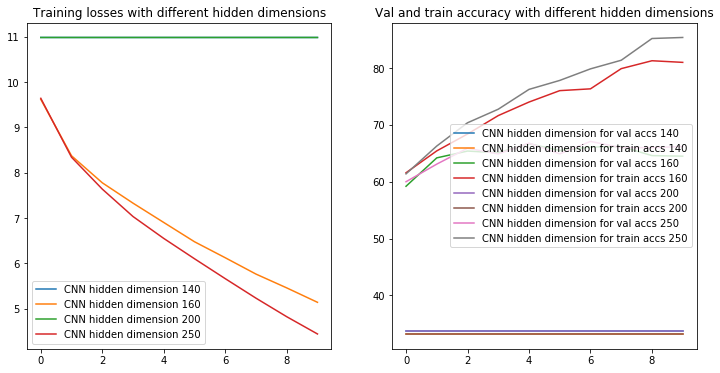

In [27]:
# Plot the results
fig, axs = plt.subplots(1,2,figsize=(12,6))
for i in range(len(train_losses[0,:])):
    axs[0].plot(train_losses[:,i],label= "CNN hidden dimension " +str(hidden_sizes[i])) 

axs[0].set_title("Training losses with different hidden dimensions")
axs[0].legend()

for i in range(len(val_accs[0,:])):
    axs[1].plot(val_accs[:,i],label= "CNN hidden dimension for val accs " +str(hidden_sizes[i])) 
    axs[1].plot(train_accs[:,i],label= "CNN hidden dimension for train accs " +str(hidden_sizes[i])) 

axs[1].set_title("Val and train accuracy with different hidden dimensions")
axs[1].legend()



---
## Investigate whether dropout helps

In [ ]:

# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F


class SNLI_CNN(nn.Module):
    def __init__(self,embeddings, emb_size, hidden_size, num_layers, num_classes, vocab_size=50000,kernel_size=3,FC_hiden=50):

        super(SNLI_CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.num_classes = num_classes
        self.emb_size = emb_size
        
        self.embed = nn.Embedding.from_pretrained(torch.from_numpy(embeddings).float(), freeze=False, sparse=False)
        
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size, padding=1)

                
        self.linear = nn.Sequential(
            #nn.Linear(hidden_size,FC_hiden),
            nn.Linear(hidden_size*2,FC_hiden),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(FC_hiden,num_classes),
            nn.ReLU())     
        
    def forward(self, data_1,data_2,length_1,length_2):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        
        batch_size_1, seq_len_1 = data_1.size()
        batch_size_2, seq_len_2 = data_2.size()

        S1 = self.embed(data_1)
        m1 = (data_1 == 1)
        #print(m1)
        m1 = m1.unsqueeze(2).repeat(1, 1, self.emb_size).float()
        S1 = m1 * S1 + (1-m1) * S1.clone().detach()
        
 
        #print(S1.size())

        S2 = self.embed(data_2)
        m2 = (data_2 == 1)
        m2 = m2.unsqueeze(2).repeat(1, 1, self.emb_size).float()
        S2 = m2 * S2 + (1-m2) * S2.clone().detach()

        
        #print(S1.size())
        
        S1 = self.conv1(S1.transpose(1,2)).transpose(1,2)
        S1 = F.relu(S1.contiguous().view(-1, S1.size(-1))).view(BATCH_SIZE, S1.size(1), S1.size(-1))

        #print(S1.size())

        S1 = self.conv2(S1.transpose(1,2)).transpose(1,2)
        S1 = F.relu(S1.contiguous().view(-1, S1.size(-1))).view(BATCH_SIZE, S1.size(1), S1.size(-1))
        
        S1 = S1.max(dim=1)
        #print(S1[0].size())

        S2 = self.conv1(S2.transpose(1,2)).transpose(1,2)
        S2 = F.relu(S2.contiguous().view(-1, S2.size(-1))).view(BATCH_SIZE, S2.size(1), S2.size(-1))

        S2 = self.conv2(S2.transpose(1,2)).transpose(1,2)
        S2 = F.relu(S2.contiguous().view(-1, S2.size(-1))).view(BATCH_SIZE, S2.size(1), S2.size(-1))
        S2 = torch.max(S2, dim=1)
        
        out = torch.cat([S1[0], S2[0]], 1)
        #print(out.size())
        
        logits = self.linear(out)
        
        return logits
    
    
    

In [28]:
hidden_sizes = [140,160,200,250]

learning_rate = 0.001
num_epochs = 10 # number epoch to train


train_losses=np.zeros((num_epochs,len(hidden_sizes)))
val_accs=np.zeros((num_epochs,len(hidden_sizes)))
train_accs=np.zeros((num_epochs,len(hidden_sizes)))

for count, em in enumerate(hidden_sizes):
    model = SNLI_CNN(loaded_embeddings_ft,emb_size=300, hidden_size=em, num_layers=2, num_classes=3,vocab_size=50000,kernel_size=2).cuda()

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        epoch_loss=[]
        val_acc = 0
        tra_acc = 0
        for i, (data_1,data_2, lengths_1,lengths_2, labels) in enumerate(train_loader):
            model.train()
            data_batch1,data_batch2,length_batch1,length_batch2,label_batch = data_1.cuda(),data_2.cuda(), lengths_1.cuda(),lengths_2.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(data_batch1,data_batch2, length_batch1,length_batch2)
            #print(outputs)
            #print(label_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            epoch_loss.append(loss)
            #print(np.array(loss))
            optimizer.step()
            # validate every 32 iterations
            if i > 0 and i % (BATCH_SIZE-1) == 0:
                # validate
                tra_acc = test_model(train_loader, model)
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))

        temp_loss = [i.detach().cpu().numpy() for i in epoch_loss]
        train_losses[epoch,count] = sum(temp_loss)/BATCH_SIZE

        train_accs[epoch,count] = tra_acc
        val_accs[epoch,count] = val_acc
    





Epoch: [1/10], Step: [100/1000], Validation Acc: 39.3
Epoch: [1/10], Step: [199/1000], Validation Acc: 46.0
Epoch: [1/10], Step: [298/1000], Validation Acc: 51.0
Epoch: [1/10], Step: [397/1000], Validation Acc: 54.0
Epoch: [1/10], Step: [496/1000], Validation Acc: 55.5
Epoch: [1/10], Step: [595/1000], Validation Acc: 54.8
Epoch: [1/10], Step: [694/1000], Validation Acc: 56.0
Epoch: [1/10], Step: [793/1000], Validation Acc: 57.0
Epoch: [1/10], Step: [892/1000], Validation Acc: 58.4
Epoch: [1/10], Step: [991/1000], Validation Acc: 56.5
Epoch: [2/10], Step: [100/1000], Validation Acc: 58.7
Epoch: [2/10], Step: [199/1000], Validation Acc: 59.5
Epoch: [2/10], Step: [298/1000], Validation Acc: 59.2
Epoch: [2/10], Step: [397/1000], Validation Acc: 58.3
Epoch: [2/10], Step: [496/1000], Validation Acc: 59.8
Epoch: [2/10], Step: [595/1000], Validation Acc: 62.6
Epoch: [2/10], Step: [694/1000], Validation Acc: 62.3
Epoch: [2/10], Step: [793/1000], Validation Acc: 63.9
Epoch: [2/10], Step: [892/10

Epoch: [6/10], Step: [298/1000], Validation Acc: 48.2
Epoch: [6/10], Step: [397/1000], Validation Acc: 47.9
Epoch: [6/10], Step: [496/1000], Validation Acc: 49.5
Epoch: [6/10], Step: [595/1000], Validation Acc: 48.5
Epoch: [6/10], Step: [694/1000], Validation Acc: 49.3
Epoch: [6/10], Step: [793/1000], Validation Acc: 49.8
Epoch: [6/10], Step: [892/1000], Validation Acc: 49.0
Epoch: [6/10], Step: [991/1000], Validation Acc: 50.1
Epoch: [7/10], Step: [100/1000], Validation Acc: 48.5
Epoch: [7/10], Step: [199/1000], Validation Acc: 49.9
Epoch: [7/10], Step: [298/1000], Validation Acc: 49.3
Epoch: [7/10], Step: [397/1000], Validation Acc: 47.9
Epoch: [7/10], Step: [496/1000], Validation Acc: 49.0
Epoch: [7/10], Step: [595/1000], Validation Acc: 48.5
Epoch: [7/10], Step: [694/1000], Validation Acc: 47.6
Epoch: [7/10], Step: [793/1000], Validation Acc: 57.7
Epoch: [7/10], Step: [892/1000], Validation Acc: 57.7
Epoch: [7/10], Step: [991/1000], Validation Acc: 56.6
Epoch: [8/10], Step: [100/10

Epoch: [1/10], Step: [496/1000], Validation Acc: 56.5
Epoch: [1/10], Step: [595/1000], Validation Acc: 55.5
Epoch: [1/10], Step: [694/1000], Validation Acc: 59.5
Epoch: [1/10], Step: [793/1000], Validation Acc: 59.8
Epoch: [1/10], Step: [892/1000], Validation Acc: 59.7
Epoch: [1/10], Step: [991/1000], Validation Acc: 61.6
Epoch: [2/10], Step: [100/1000], Validation Acc: 63.3
Epoch: [2/10], Step: [199/1000], Validation Acc: 62.2
Epoch: [2/10], Step: [298/1000], Validation Acc: 60.0
Epoch: [2/10], Step: [397/1000], Validation Acc: 61.6
Epoch: [2/10], Step: [496/1000], Validation Acc: 60.7
Epoch: [2/10], Step: [595/1000], Validation Acc: 59.0
Epoch: [2/10], Step: [694/1000], Validation Acc: 59.1
Epoch: [2/10], Step: [793/1000], Validation Acc: 63.5
Epoch: [2/10], Step: [892/1000], Validation Acc: 63.2
Epoch: [2/10], Step: [991/1000], Validation Acc: 63.0
Epoch: [3/10], Step: [100/1000], Validation Acc: 63.6
Epoch: [3/10], Step: [199/1000], Validation Acc: 64.2
Epoch: [3/10], Step: [298/10

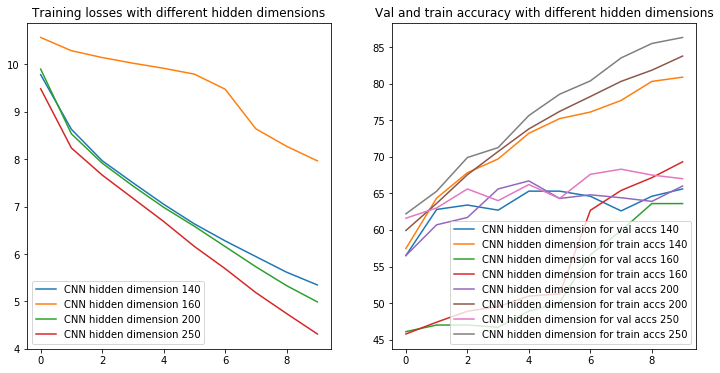

In [29]:
# Plot the results
fig, axs = plt.subplots(1,2,figsize=(12,6))
for i in range(len(train_losses[0,:])):
    axs[0].plot(train_losses[:,i],label= "CNN hidden dimension " +str(hidden_sizes[i])) 

axs[0].set_title("Training losses with different hidden dimensions")
axs[0].legend()

for i in range(len(val_accs[0,:])):
    axs[1].plot(val_accs[:,i],label= "CNN hidden dimension for val accs " +str(hidden_sizes[i])) 
    axs[1].plot(train_accs[:,i],label= "CNN hidden dimension for train accs " +str(hidden_sizes[i])) 

axs[1].set_title("Val and train accuracy with different hidden dimensions")
axs[1].legend()

